# MNIST 손글씨 분류기 구현

## 구글 드라이브 마운트

In [1]:
import os
from google.colab import drive

mount_point = './mnt'
drive.mount(mount_point)

Mounted at ./mnt


In [2]:
mount_path = os.path.abspath(mount_point)
data_path = os.path.join(mount_path, 'My Drive/Colab Notebooks/data/mnist/')
print(data_path)

/content/mnt/My Drive/Colab Notebooks/data/mnist/


## 라이브러리 임포트

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset

## 데이터셋 클래스

In [4]:
class MnistDataset(Dataset): 
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        label = self.df.iloc[index,0]

        # 출력 데이터 One-Hot 인코딩
        target = torch.zeros((10))
        target[label] = 1.0
        
        # 입력 데이터 정규화(Normalization)
        image = torch.FloatTensor(self.df.iloc[index,1:].values) / 255.0
        
        return label, image, target
    
    def show(self, index):
        img = self.df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.df.iloc[index,0]))
        plt.imshow(img, cmap='Greys')

## 데이터 로드

In [5]:
train_ds = MnistDataset(data_path + 'mnist_train.csv')

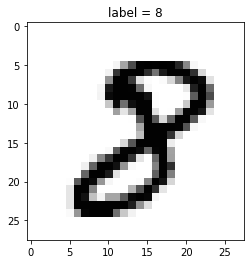

In [6]:
train_ds.show(1214)

## 신경망 모델 클래스

In [7]:
class MnistClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(784, 300),
            nn.Sigmoid(),
            nn.Linear(300, 10),
            nn.Sigmoid()
        )
        
        self.loss_function = nn.MSELoss()
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

## 신경망 모델 학습(Training)

In [8]:
%%time 
mnist  = MnistClassifier()
epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image, target in train_ds:
        mnist.train(image, target)

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 3min 27s, sys: 2.14 s, total: 3min 29s
Wall time: 3min 29s


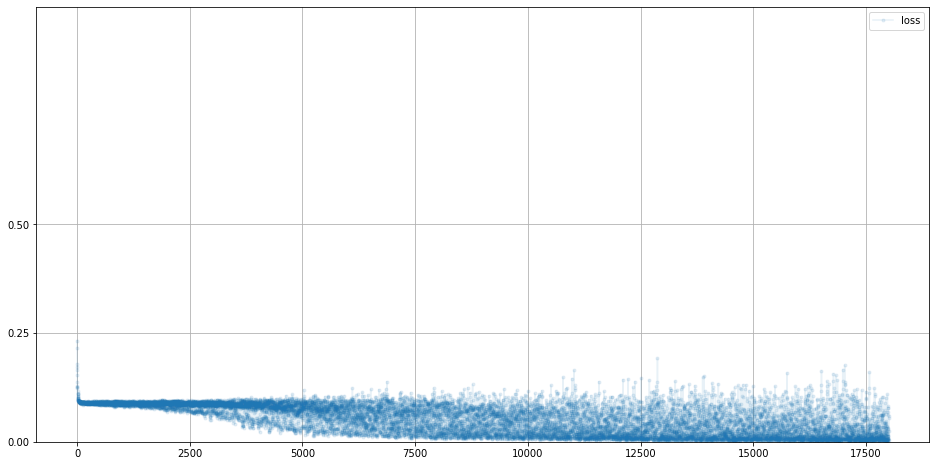

In [9]:
# plot classifier loss
mnist.plot()

## 분류기 사용

In [10]:
test_ds = MnistDataset(data_path + 'mnist_test.csv')

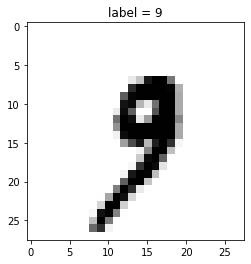

In [11]:
index = 1000
test_ds.show(index)

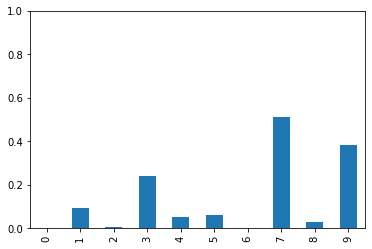

In [12]:
image_data = test_ds[index][1]
output = mnist.forward(image_data)
pd.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

## 분류기 성능 측정

In [13]:
score = 0
items = 0

for label, image, target in test_ds:
    answer = mnist.forward(image).detach().numpy()
    if (answer.argmax() == label):
        score += 1
    items += 1
    
print(f'items : {items:,} score : {score:,} 정확도 : {score/items*100:.2f}')

items : 10,000 score : 8,658 정확도 : 86.58


## 분류기 성능 향상

In [14]:
class MnistClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(784, 300),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(300),   
            nn.Linear(300, 10),
            nn.Sigmoid()
        )
        
        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.Adam(self.parameters())
        self.counter = 0
        self.progress = []
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot(self):
        df = df.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))